In [52]:
import importlib
import matplotlib.pyplot as plt
import json
import random
import torch
from tqdm.notebook import tqdm

import utils
import load_embeddings

importlib.reload(utils)#this makes sure that any changes to the file are imported
importlib.reload(load_embeddings)

vocab_size = 151936
dimensions = 1536


In [54]:
with open('data/wordlist.json', 'r') as f:
    data_dict = json.load(f)

print(data_dict.keys())

dict_keys(['mammals', 'birds', 'reptiles', 'amphibians', 'fish', 'trees', 'flowers', 'fruits', 'vegetables', 'colors', 'textures', 'sizes'])


In [56]:
model, tokenizer = load_embeddings.load_embedding_model(
    vocab_size,
    dimensions,
    "models/embeddings_qwen.pth",
    "models/unembeddings_qwen.pth",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
)
model.eval()

SimpleModel(
  (embedding): Embedding(151936, 1536)
  (unembedding): Linear(in_features=1536, out_features=151936, bias=False)
)

### Experiment A

Visualisations produced for each number of superpositions:
- Percentage of cases where the superposed words are contained in the top k logits
- Average inverse position of the last position word in the probability distribution
- Comparing cases where words come from the same category // random sampling

In [58]:
def experiment_loop(
    word_list,
    model,
    tokenizer,
    n_values=[2, 3, 4, 5, 6, 7, 8, 9, 10],
    num_trials=100,
    top_k_scale=3,
    uniform=True
):
    """
    Run superposition experiments on a given vocabulary list.

    For each n in n_values:
      - Randomly sample n words (single-token only)
      - Build uniform superposition (mean embedding)
      - Use unembedding to get logits and take top_k
      - Count how many sampled words appear in top_k (by token id)
      - Average the success counts over num_trials

    Returns:
      dict(dict): {
          avg_success: { n: avg_success },
          avg_inv_pos_first: {n: avg_inv_pos},
          avg_inv_pos_last: {n: avg_inv_pos}
          }

    Notes:
      - Uses existing helpers where applicable:
          * token_len_one_verifier
          * get_token_embedding (as a stand-in for get_embedding_from_word)
        We compute top-k indices directly via model.unembedding to avoid
        string matching issues (leading spaces, special tokens) and to mirror
        the requested "top_k_indices(logits)" behavior.
    """

    # Filter word_list to single-token words only
    candidates = [w for w in word_list if utils.token_len_one_verifier(tokenizer, w)]

    if not candidates:
        raise ValueError("No single-token words available after filtering. Please adjust word_list.")

    precomputed = {}
    for w in candidates:
        tok_ids = tokenizer.encode(w, add_special_tokens=False)
        if len(tok_ids) != 1:
            continue
        tok_id = tok_ids[0]
        emb = utils.get_token_embedding(model, tokenizer, w)
        precomputed[w] = {"id": tok_id, "emb": emb}

    candidates = [w for w in candidates if w in precomputed]
    if not candidates:
        raise ValueError("No valid single-token words with embeddings. Please adjust word_list.")

    results = {}
    results['avg_success'] = {}
    results['avg_inv_pos_first'] = {}
    results['avg_inv_pos_last'] = {}

    for n in n_values:
        if n <= 0:
            print(f"[test_combinations] Skipping n={n}: only values >= 0 are accepted.")
            continue
        if n > len(candidates):
            print(f"[test_combinations] Skipping n={n}: only {len(candidates)} single-token candidates available.")
            continue

        print(f'Computing for superposition of size {n}')
        total_success = 0.0
        total_inv_rank_last = 0.0
        total_inv_rank_first = 0.0

        for _ in tqdm(range(num_trials), leave=False):
            sampled_words = random.sample(candidates, n)

            emb_stack = torch.stack([precomputed[w]["emb"] for w in sampled_words], dim=0)
            if uniform:
                combined_emb = emb_stack.mean(dim=0)
            else:
                weights = torch.nn.softmax(torch.tensor([i for i in range(n)])).unsqueeze(0)#create a non-uniform distribution (increasing weight)
                combined_emb = emb_stack * weights

            if not isinstance(combined_emb, torch.Tensor):
                combined_emb = torch.tensor(combined_emb)
            logits = model.unembedding(combined_emb.unsqueeze(0))  # [1, vocab]

            sampled_ids = [precomputed[w]["id"] for w in sampled_words]
            sorted_logits = torch.sort(logits, descending=True).indices.flatten()
            success_count = 0
            curr_found = 0
            ids_to_find = len(sampled_ids)
            
            for i in range(n * top_k_scale * 10):
                if sorted_logits[i] in sampled_ids:
                    curr_found += 1
                    
                    if i < (n * top_k_scale):
                        success_count += 1
                        
                    if curr_found == 1:
                        total_inv_rank_first += 1/(i + 1)

                    if curr_found == ids_to_find:
                        total_inv_rank_last += 1/(i + 1)
                        break

            total_success += success_count

        results['avg_success'][n] = total_success / float(num_trials)
        results['avg_inv_pos_first'][n] = total_inv_rank_first / float(num_trials)
        results['avg_inv_pos_last'][n] = total_inv_rank_last / float(num_trials)

    print("Done!")
    return results

In [61]:
test_word_list = data_dict['colors']
scaler = 3
test_results = experiment_loop(test_word_list, model, tokenizer, top_k_scale=scaler)
print(test_results)

Computing for superposition of size 2


  0%|          | 0/100 [00:00<?, ?it/s]

Computing for superposition of size 3


  0%|          | 0/100 [00:00<?, ?it/s]

Computing for superposition of size 4


  0%|          | 0/100 [00:00<?, ?it/s]

Computing for superposition of size 5


  0%|          | 0/100 [00:00<?, ?it/s]

Computing for superposition of size 6


  0%|          | 0/100 [00:00<?, ?it/s]

Computing for superposition of size 7


  0%|          | 0/100 [00:00<?, ?it/s]

Computing for superposition of size 8


  0%|          | 0/100 [00:00<?, ?it/s]

Computing for superposition of size 9


  0%|          | 0/100 [00:00<?, ?it/s]

Computing for superposition of size 10


  0%|          | 0/100 [00:00<?, ?it/s]

Done!
{'avg_success': {2: 2.0, 3: 2.93, 4: 3.38, 5: 2.78, 6: 2.01, 7: 1.35, 8: 0.92, 9: 0.49, 10: 0.35}, 'avg_inv_pos_first': {2: 1.0, 3: 1.0, 4: 1.0, 5: 0.8908888888888888, 6: 0.6051104645354647, 7: 0.3230246847695941, 8: 0.13717182114357093, 9: 0.06322233165873252, 10: 0.03670446168373945}, 'avg_inv_pos_last': {2: 0.5, 3: 0.28498073870573837, 4: 0.08074787605395846, 5: 0.007678963572242421, 6: 0.0003822217382459946, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}}


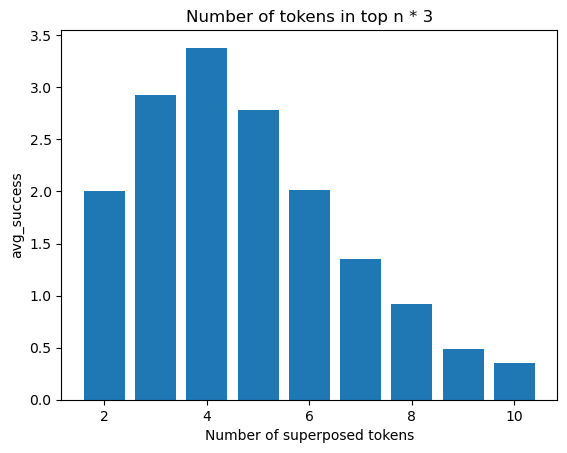

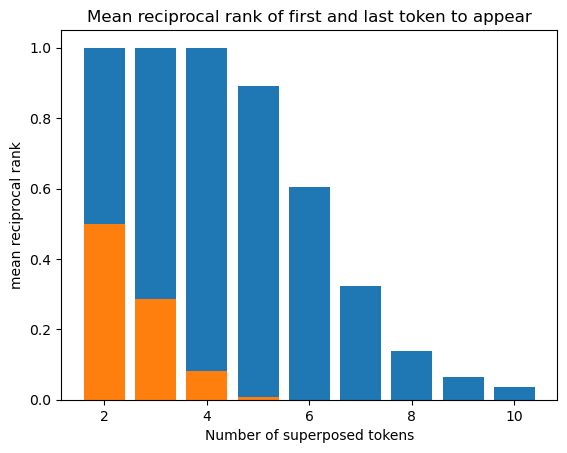

In [63]:
importlib.reload(utils)

utils.plot_results_bar(test_results['avg_success'], f'Number of tokens in top n * {scaler}', 'avg_success')
utils.plot_results_bar_multi(test_results['avg_inv_pos_first'], test_results['avg_inv_pos_last'], 'Mean reciprocal rank of first and last token to appear', 'mean reciprocal rank')